In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, jvp
from numba import njit

In [64]:
c = 3*1e8
R = 75*1e-9
lamb = 1064*1e-9
a = 4.5*1e-6 #fiber radius
n1 = 1.446 #core refractive index
n2 = 1.44 #cladding refractive index
n_md = 1  # medium refractive index (??)
n_p = 1.46 # particle refractive index
P=800*1e-3 #W
eta_air = 18.27e-6 # Pa # (J.T.R.Watson (1995)).
m_gas = 4.81e-26 # molecular mass of air
Pressure_atm = 1013.25 #mbar (=1 atm)
d_gas = 0.372e-9 #m #(Sone (2007)), ρSiO2
density = 1850  # kg/m³ (SiO2)
T = 297 # K
kB = 1.380649e-23 # J/K

In [65]:
l=0

w_0=0.65*a
volume = (4/3) * np.pi * (R**3)
m = density * volume  # kg
NA = ((n1**2)-(n2**2))**(1/2)
k = 2*np.pi/lamb
m_rri = n_p/n_md
X_root = 1.845
beta_f = ((n1**2)*(k**2)-(X_root/a)**2)**(1/2)
kt = ((n1**2)*(k**2)-beta_f**2)**(1/2)
gamma_fiber = ((beta_f**2)-(n2**2)*(k**2))**(1/2)

In [66]:
w_0

2.9250000000000004e-06

In [67]:
N = 100_000_000
dt = 1e-9

In [68]:
A=1

def F_space(x, y):
    r = np.sqrt(x**2 + y**2) + 1e-30

    alpha_fac = (2 * np.pi * n_md * (R**3) / c) * (((m_rri**2) - 1) / ((m_rri**2) + 2))
    F_0 = (P / (2 * np.pi * (w_0**2))) * alpha_fac

    fx =  F_0 * (2 * A**2 * jv(l, kt * r) * jvp(l, kt * r) * kt * x / r)
    fy =  F_0 * (2 * A**2 * jv(l, kt * r) * jvp(l, kt * r) * kt * y / r)
    fz = -F_0 * (2 * k * A**2)

    return fx, fy, fz

def jv_func(x,y):
    r = np.sqrt(x**2 + y**2) + 1e-30
    return jv(l, kt * r)

In [69]:
@njit(fastmath=True)
def Gamma_env(Pressure_mbar):
    def mfp(P_gas):
        mfp_val = kB*T/(2**0.5*np.pi*d_gas**2*P_gas)
        return mfp_val
    
    Pressure_pascals = 100*Pressure_mbar
    s = mfp(Pressure_pascals)
    K_n = s/R
    c_K = 0.31*K_n/(0.785 + 1.152*K_n + K_n**2)
    gamma = 6*np.pi*eta_air*R/m * 0.619/(0.619 + K_n) * (1+c_K)
    return gamma #Isso está em Hz

@njit(fastmath=True)
def P_grad(pos):
    z_max = 8*1e-3

    Pi = 100
    Pf = 1e-8
    return Gamma_env(Pi + ((Pf-Pi)/z_max)*pos)

@njit(fastmath=True)
def dx_dt(v):
    return v

@njit(fastmath=True)
def dv_dt(pos,F_total_z,v,gamma_hz):
    return F_total_z/m - gamma_hz*v

In [70]:
x_ax = np.linspace(-5e-6, 5e-6, N)
y_ax = np.linspace(-5e-6, 5e-6, N)
z_ax = np.linspace(-5e-7, 1*1e-3, N)
t = np.linspace(0,dt*N,N)

Force_x=F_space(x_ax, 0)[0]
Force_y=F_space(0, y_ax)[1]
Force_z=F_space(0, 0)[2]
jv_aux = jv_func(x_ax,y_ax)

#1m 53.7s for N=100_000_000

In [ ]:
@njit(fastmath=True)
def runge_kutta(v_init, pos_init, beta):
    positions =  np.zeros((N, 3))
    velocities = np.zeros((N, 3))
    
    positions[0, :] = pos_init
    velocities[0, :] = v_init

    for i in range(N - 1):
        cos_term = np.cos(np.remainder(2 * k * positions[i,2] - 2*np.pi*beta*(i*dt)**2,2*np.pi))
        sin_term = np.sin(np.remainder(2 * k * positions[i,2] - 2*np.pi*beta*(i*dt)**2,2*np.pi))

        Fx = np.interp(positions[i, 0], x_ax, Force_x)
        Fy = np.interp(positions[i, 1], y_ax, Force_y)
        jv_auxiliar = np.interp(positions[i, 0], x_ax, jv_aux)
        Fz = Force_z*jv_auxiliar**2 #np.interp(positions[i, 2], z_ax, Force_z)
        Fs = np.array([Fx*cos_term, Fy*cos_term, Fz*sin_term])

        gamma_hz = P_grad(positions[i, 2])

        k1_pos = velocities[i] * dt
        k1_v = np.array([dv_dt(positions[i, j], Fs[j], velocities[i, j], gamma_hz=gamma_hz) for j in range(3)]) * dt

        k2_pos = (velocities[i] + 0.5 * k1_v) * dt
        k2_v = np.array([dv_dt(positions[i, j] + 0.5 * k1_pos[j], Fs[j], velocities[i, j] + 0.5 * k1_v[j],gamma_hz=gamma_hz) for j in range(3)]) * dt

        k3_pos = (velocities[i] + 0.5 * k2_v) * dt
        k3_v = np.array([dv_dt(positions[i, j] + 0.5 * k2_pos[j], Fs[j], velocities[i, j] + 0.5 * k2_v[j],gamma_hz=gamma_hz) for j in range(3)]) * dt

        k4_pos = (velocities[i] + k3_v) * dt
        k4_v = np.array([dv_dt(positions[i, j] + k3_pos[j], Fs[j], velocities[i, j] + k3_v[j],gamma_hz=gamma_hz) for j in range(3)]) * dt

        positions[i + 1] = positions[i] + (1.0 / 6.0) * (k1_pos + 2 * k2_pos + 2 * k3_pos + k4_pos)
        velocities[i + 1] = velocities[i] + (1.0 / 6.0) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)

        thermal_noise = np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal(0, 1, 3) * np.sqrt(dt) / m
        velocities[i + 1] += thermal_noise

    return positions, velocities

In [ ]:
x0 = np.array([0.0, 0.0, 0.0]) #(dt)*np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal() * np.sqrt(dt) / m
v0 = np.array([0.0, 0.0, 0.0]) #np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal() * np.sqrt(dt) / m

beta = 1e5
positions, velocities = runge_kutta(v0,x0,beta=beta)

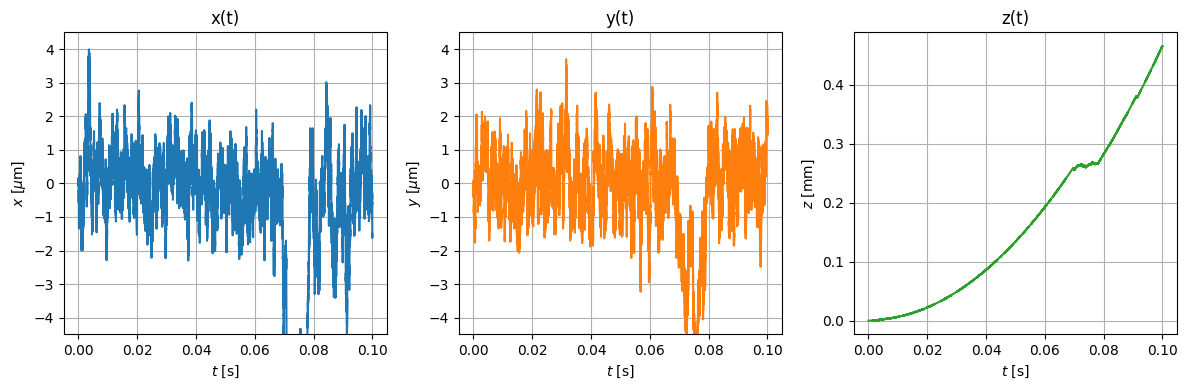

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
l = 0

t = np.arange(N)*dt

axs[0].plot(t[::10], positions[::10,0]*1e6, color='#1f77b4')
axs[0].set_ylim(-a*1e6, a*1e6)
axs[0].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
axs[0].set_ylabel(r'$x\ \left[\mu\mathrm{m}\right]$')
axs[0].set_title("x(t)")
axs[0].grid(True)

axs[1].plot(t[::10], positions[::10,1]*1e6, color='#ff7f0e')
axs[1].set_ylim(-a*1e6, a*1e6)
axs[1].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
axs[1].set_ylabel(r'$y\ \left[\mu\mathrm{m}\right]$')
axs[1].set_title("y(t)")
axs[1].grid(True)

axs[2].plot(t[::10], positions[::10,2]*1e3, color='#2ca02c')
#axs[2].set_ylim(-1e-3, 1e-1)
axs[2].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
axs[2].set_ylabel(r'$z\ \left[\mathrm{mm}\right]$')
axs[2].set_title("z(t)")
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
vz = np.gradient(positions[:, 2], dt)

v_max = np.max(np.abs(vz))
velocidade_final = (beta*dt*N)/(2*k)

#print(f'Maximum velocity of the lattice: {velocidade_final:.3e} m/s')
#print(f'Maximum velocity of the particle: {v_max*1e3:.3e} mm/s')
plt.plot(t[::100],vz[::100])
plt.plot(t[::100],((beta*t)/(k))[::100])


plt.ylabel(r'$velocity\ \left[\mathrm{m/s}\right]$')
plt.xlabel(r'$t\ \left[\mathrm{s}\right]$')
plt.grid(True)
plt.show()